In [1]:
import pandas as pd
import numpy as np
import numpy.random as nr

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import math



from sklearn import preprocessing
import sklearn.model_selection as ms
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
import sklearn.metrics as sklm
from sklearn import feature_selection as fs
from sklearn import metrics
from sklearn.model_selection import cross_validate



%matplotlib inline

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points
import warnings
warnings.filterwarnings('ignore')


In [2]:
raw_train_values = pd.read_csv('train_values_oAriVNN.csv')
train_labels = pd.read_csv('train_labels.csv')

id_values=raw_train_values['row_id']
id_labels=train_labels['row_id']

train_labels = train_labels.drop(['row_id'],axis=1)
raw_train_values = raw_train_values.drop(['row_id'],axis=1)

raw_df = pd.concat([raw_train_values,train_labels],axis=1)

## 1. Exploring Raw Data

In [3]:
print(raw_df.shape)

(2546, 48)


### 1.1. Separe num colums and text columns

In [4]:
# text columns
texto = raw_df.dtypes ==object
raw_text_cols = [c for c in texto.index if texto[c]]
raw_text_cols

['county_code',
 'year',
 'state',
 'rucc',
 'urban_influence',
 'economic_typology']

In [5]:
# get just number columns
num =(raw_df.dtypes == float) | (raw_df.dtypes==np.int64)
raw_num_cols = [c for c in num.index if num[c]]
raw_num_cols

['population',
 'renter_occupied_households',
 'pct_renter_occupied',
 'median_gross_rent',
 'median_household_income',
 'median_property_value',
 'rent_burden',
 'pct_white',
 'pct_af_am',
 'pct_hispanic',
 'pct_am_ind',
 'pct_asian',
 'pct_nh_pi',
 'pct_multiple',
 'pct_other',
 'poverty_rate',
 'pct_civilian_labor',
 'pct_unemployment',
 'pct_uninsured_adults',
 'pct_uninsured_children',
 'pct_adult_obesity',
 'pct_adult_smoking',
 'pct_diabetes',
 'pct_low_birthweight',
 'pct_excessive_drinking',
 'pct_physical_inactivity',
 'air_pollution_particulate_matter_value',
 'homicides_per_100k',
 'motor_vehicle_crash_deaths_per_100k',
 'heart_disease_mortality_per_100k',
 'pop_per_dentist',
 'pop_per_primary_care_physician',
 'pct_female',
 'pct_below_18_years_of_age',
 'pct_aged_65_years_and_older',
 'pct_adults_less_than_a_high_school_diploma',
 'pct_adults_with_high_school_diploma',
 'pct_adults_with_some_college',
 'pct_adults_bachelors_or_higher',
 'birth_rate_per_1k',
 'death_rate_p

### 1.2. Explorer the target

In [6]:
raw_df['evictions'].describe()

count    2546.000
mean      378.048
std      1405.277
min         0.000
25%         4.000
50%        29.000
75%       160.750
max     29251.000
Name: evictions, dtype: float64

min value is 0

In [7]:
(raw_df['evictions']==0).value_counts()

False    2208
True      338
Name: evictions, dtype: int64

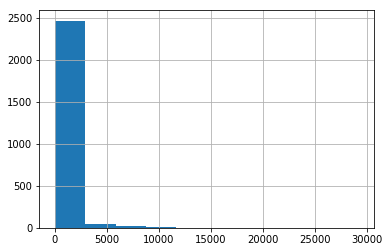

In [8]:
count, division = np.histogram(raw_df['evictions'])

raw_df['evictions'].hist(bins=division)

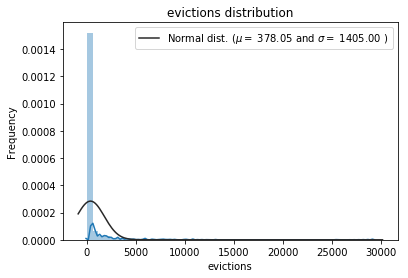

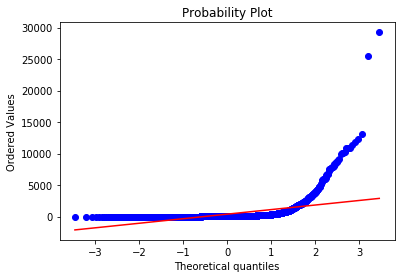

In [9]:
(mu, sigma) = ss.norm.fit(raw_df['evictions'])
sns.distplot(raw_df['evictions'], fit=ss.norm);

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('evictions distribution')

fig = plt.figure()
res = ss.probplot(raw_df['evictions'], plot=plt)
plt.show()



### 1.3. Plot  Raw data

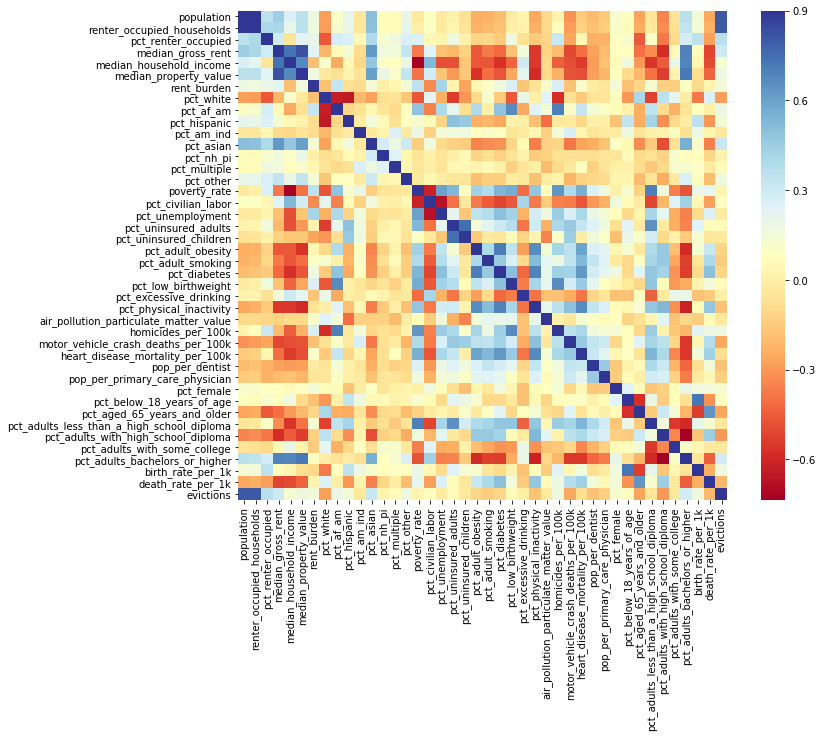

In [10]:
corrmat = raw_df[raw_num_cols].corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True,cmap="RdYlBu")

### 1.4. explorer fertures

In [11]:
HOUSING_COLS =['renter_occupied_households',
              'pct_renter_occupied',
              'median_gross_rent',
              'median_household_income',
              'median_property_value',
              'rent_burden']

ETHNICITY_COLS =['pct_white',
                'pct_af_am',
                'pct_hispanic',
                'pct_am_ind',
                'pct_asian',
                'pct_nh_pi',
                'pct_multiple',
                'pct_other']

ECONOMIC_COLS =['poverty_rate',
               'pct_civilian_labor',
               'pct_unemployment']

HEALTH_COLS = ['pct_uninsured_adults',
              'pct_uninsured_children',
              'pct_adult_obesity',
              'pct_diabetes',
              'pct_low_birthweight',
              ]

***ETHNICITY_COLS***

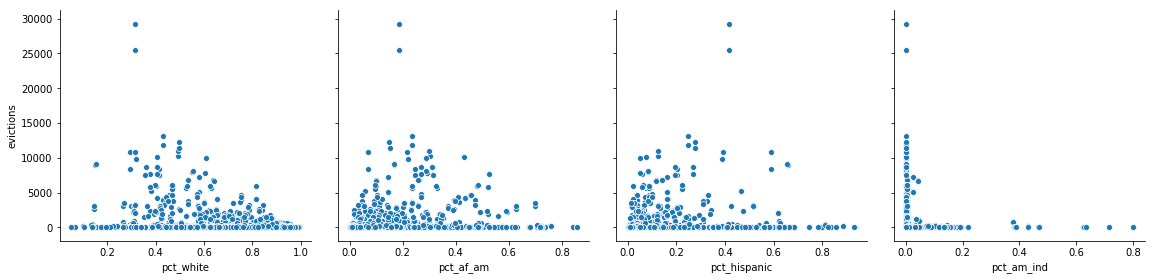

In [12]:
sns.pairplot(raw_df,
             y_vars= ['evictions'],
             x_vars=ETHNICITY_COLS[:4],
             height=4,
            )

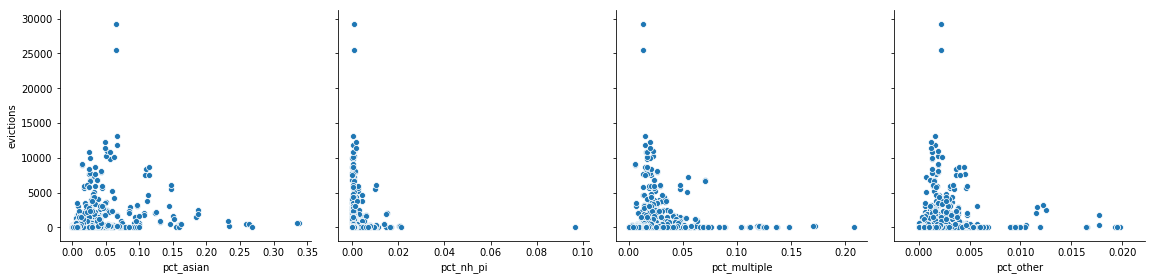

In [13]:
sns.pairplot(raw_df,
             y_vars= ['evictions'],
             x_vars=ETHNICITY_COLS[4:],
             height=4)

***HOUSING_COLS***

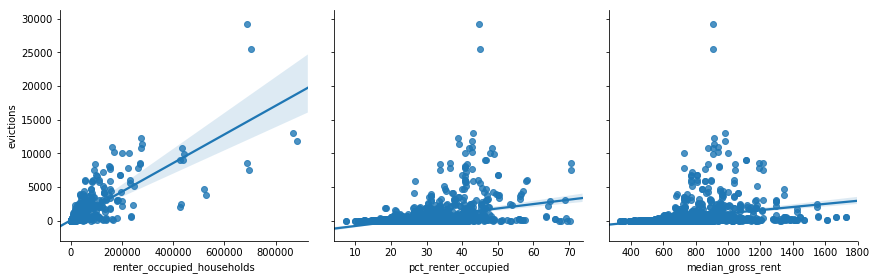

In [14]:
sns.pairplot(data=raw_df,
             y_vars= ['evictions'],
             x_vars=HOUSING_COLS[:3],
             kind='reg',
            height=4)

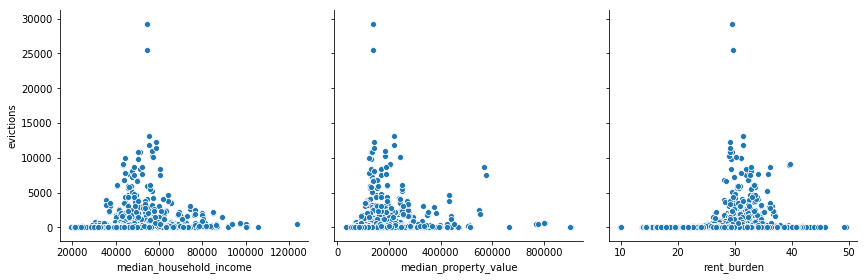

In [15]:
sns.pairplot(data=raw_df,
             y_vars= ['evictions'],
             x_vars=HOUSING_COLS[3:],
             height=4)

***ECONOMIC_COLS***

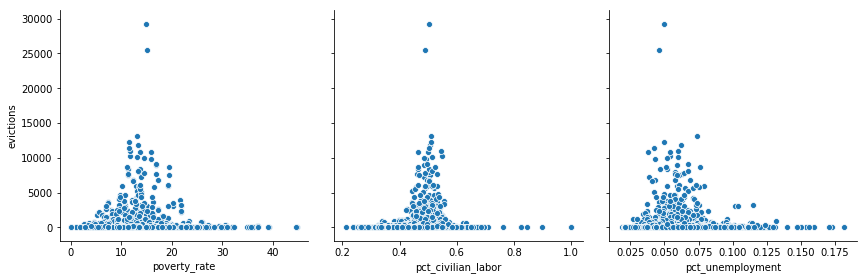

In [16]:
sns.pairplot(data=raw_df,
            y_vars= ['evictions'],
            x_vars=ECONOMIC_COLS,
            height=4)

# 2. Clean dataset

In [17]:
# searh missing data in text df
raw_df[raw_text_cols].notnull().apply(pd.Series.value_counts).T
#there are not nulls ok

,True
county_code,2546
year,2546
state,2546
rucc,2546
urban_influence,2546
economic_typology,2546


In [18]:
# searh missing data in num df
available_data = raw_df.notnull().apply(pd.Series.value_counts).T
available_data.columns = ['A','B']
not_available_data= available_data[available_data['A']>0]
not_available_data

,A,B
median_household_income,2.000,2544.000
median_property_value,2.000,2544.000
pct_adult_smoking,408.000,2138.000
pct_low_birthweight,126.000,2420.000
pct_excessive_drinking,810.000,1736.000
air_pollution_particulate_matter_value,1.000,2545.000
homicides_per_100k,1598.000,948.000
motor_vehicle_crash_deaths_per_100k,308.000,2238.000
pop_per_dentist,190.000,2356.000
pop_per_primary_care_physician,175.000,2371.000


In [19]:
#try the understand if there are predict power  columns with nulls

columns_with_nulls = available_data[available_data['A']>0].index
data_with_nulls = raw_df[columns_with_nulls]
concat_nulls=pd.concat([data_with_nulls,train_labels],axis=1)
corr_evictions = concat_nulls.corr()['evictions'].drop(['evictions'])
not_available_data['Corr']=corr_evictions
not_available_data


,A,B,Corr
median_household_income,2.000,2544.000,0.131
median_property_value,2.000,2544.000,0.174
pct_adult_smoking,408.000,2138.000,-0.146
pct_low_birthweight,126.000,2420.000,0.061
pct_excessive_drinking,810.000,1736.000,0.001
air_pollution_particulate_matter_value,1.000,2545.000,-0.034
homicides_per_100k,1598.000,948.000,0.172
motor_vehicle_crash_deaths_per_100k,308.000,2238.000,-0.257
pop_per_dentist,190.000,2356.000,-0.176
pop_per_primary_care_physician,175.000,2371.000,-0.132


In [20]:
columns_with_nulls=columns_with_nulls.drop(['median_household_income','median_property_value'])
columns_with_nulls

Index(['pct_adult_smoking', 'pct_low_birthweight', 'pct_excessive_drinking',
       'air_pollution_particulate_matter_value', 'homicides_per_100k',
       'motor_vehicle_crash_deaths_per_100k', 'pop_per_dentist',
       'pop_per_primary_care_physician'],
      dtype='object')

In [21]:
#we can conclude, there are not a strog correlations to loss data

df_clean = raw_df.drop(columns_with_nulls, axis=1)
df_clean= df_clean.fillna(df_clean.mean())
df_clean.shape


(2546, 40)

 Outliers no applied because there aren't strong linear relation

### 2.1.  Explorer Clean DF Interesting feature

In [22]:
int_cols = (['renter_occupied_households',
             'rent_burden',
             'median_gross_rent',
             'pct_unemployment',
             'poverty_rate',
             'pct_renter_occupied',             
             'pct_adults_less_than_a_high_school_diploma',
             'pct_white',
             'pct_af_am',
             'evictions' ])

In [23]:
# get just number columns
num =(df_clean.dtypes == float) | (df_clean.dtypes==np.int64)
num_cols = [c for c in num.index if num[c]]


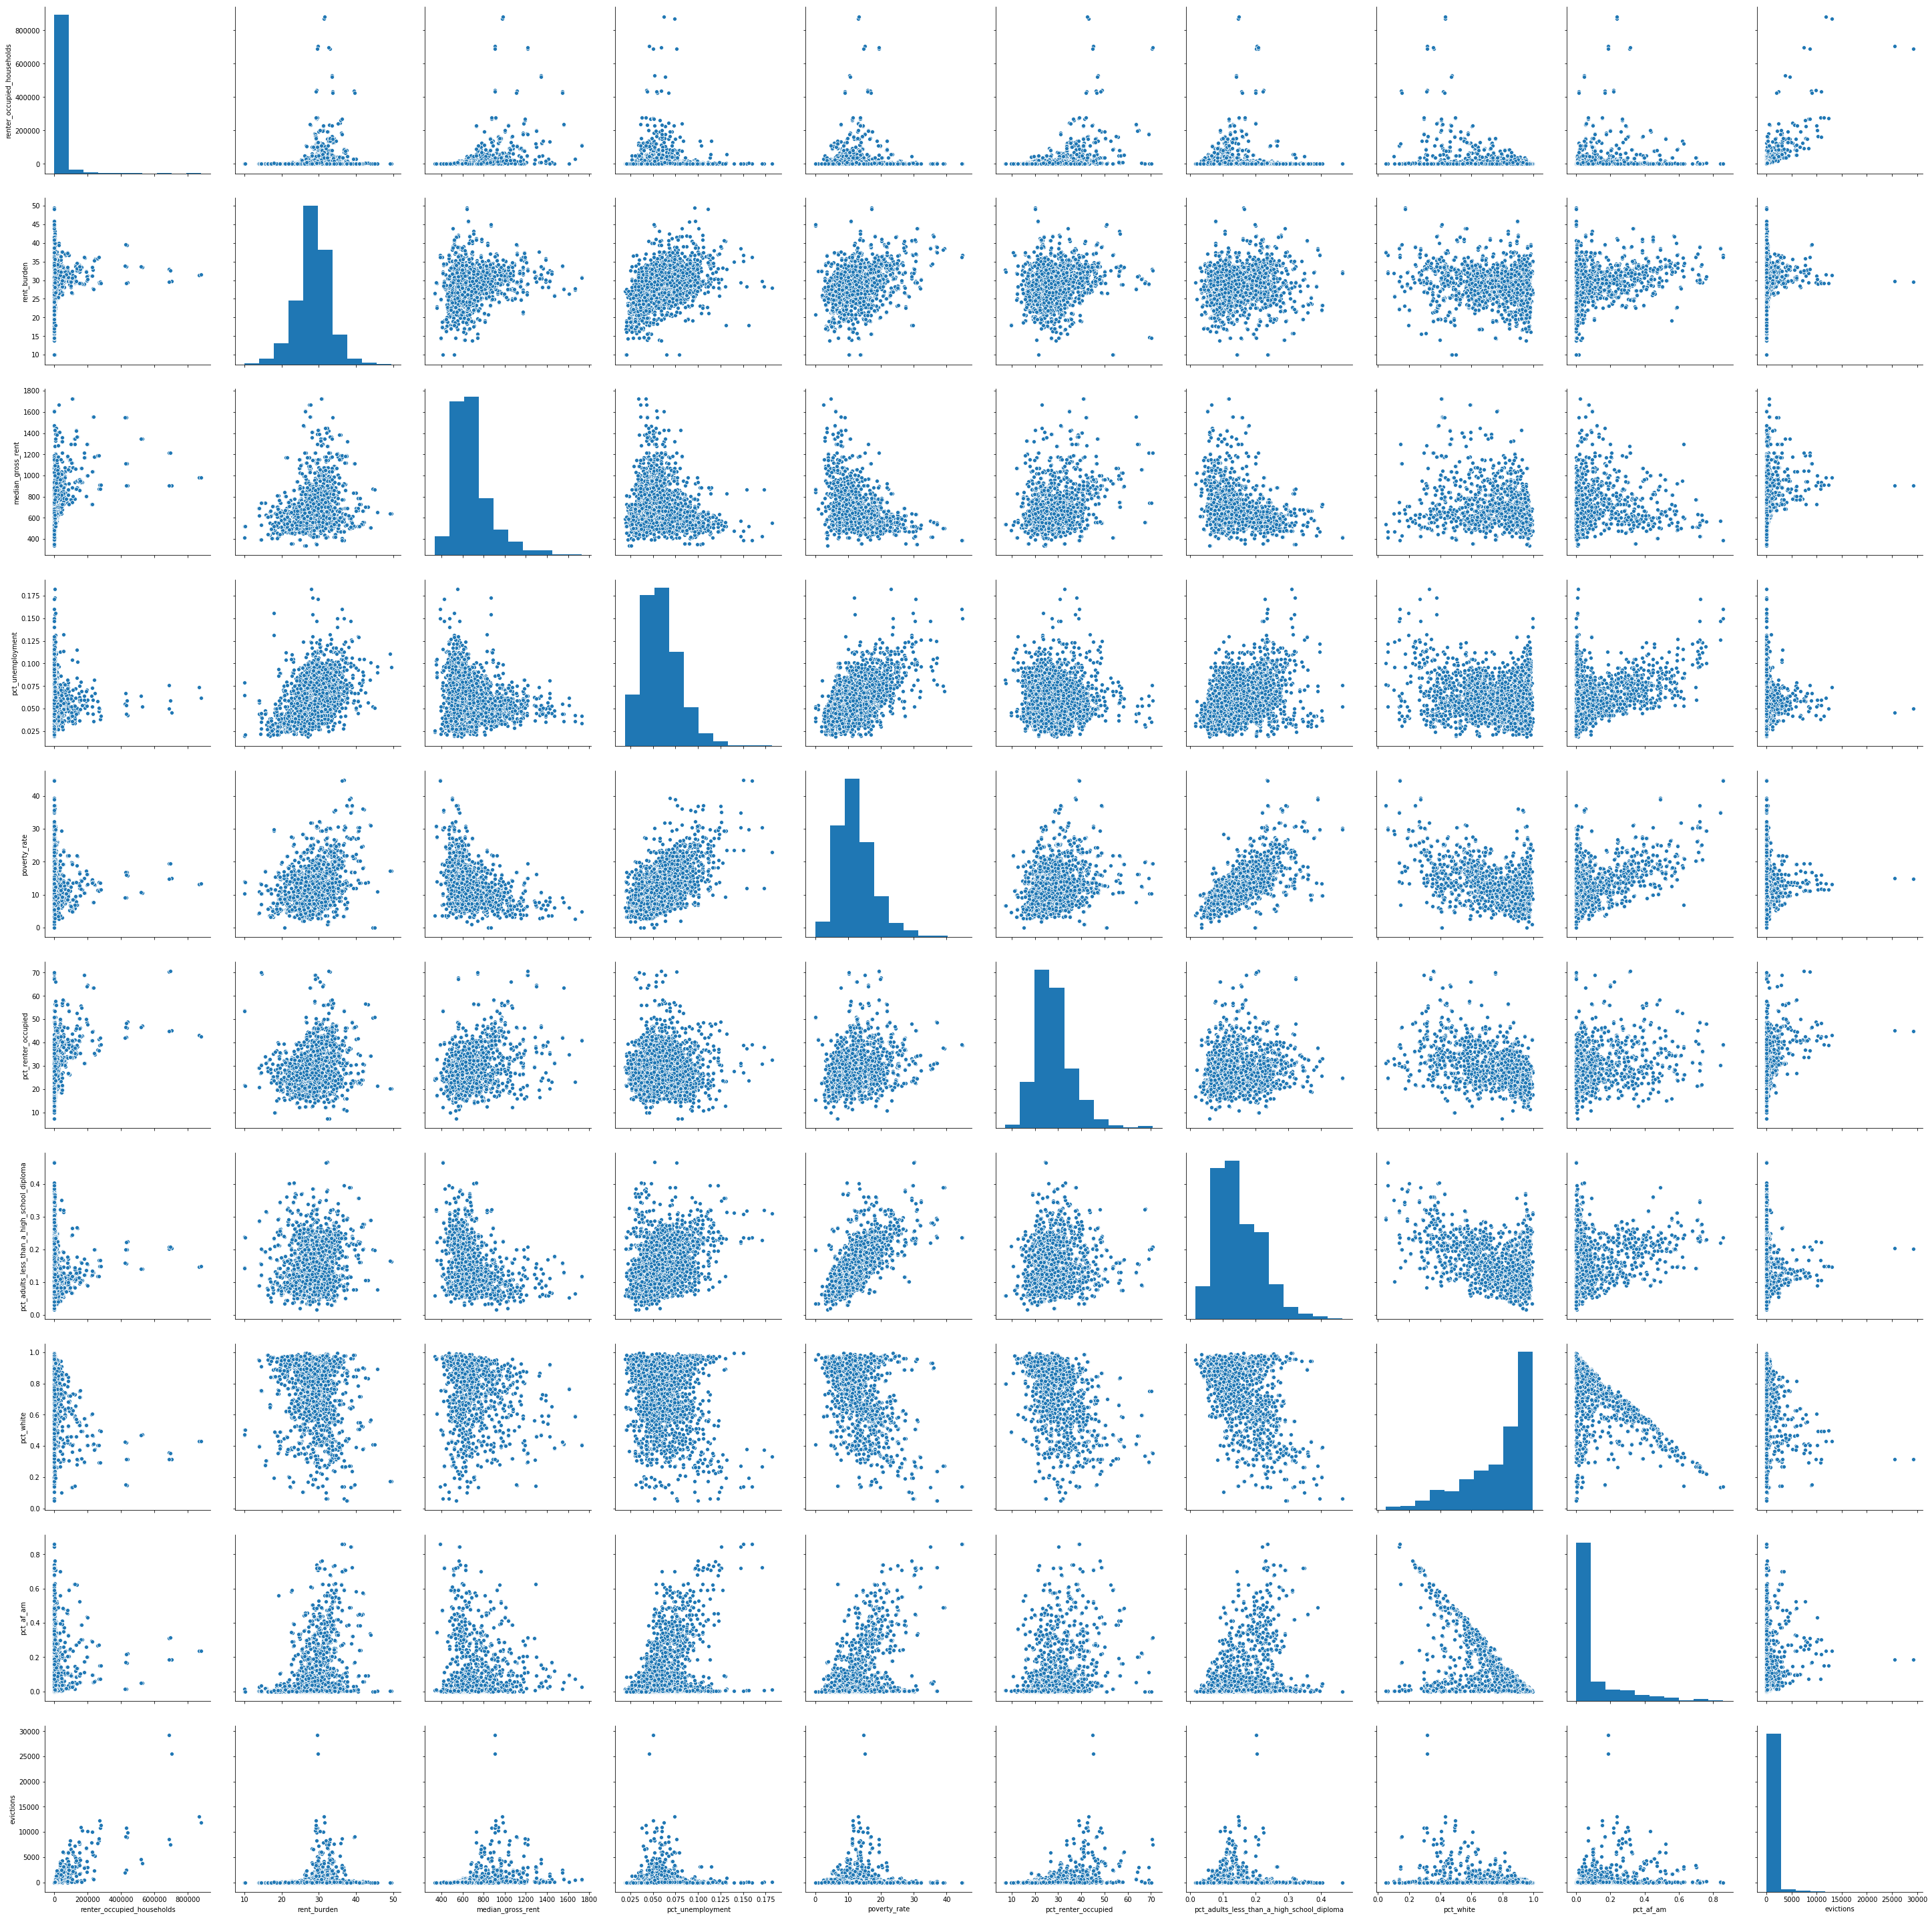

In [24]:
sns.pairplot(df_clean,
             vars=int_cols,
            height=4)

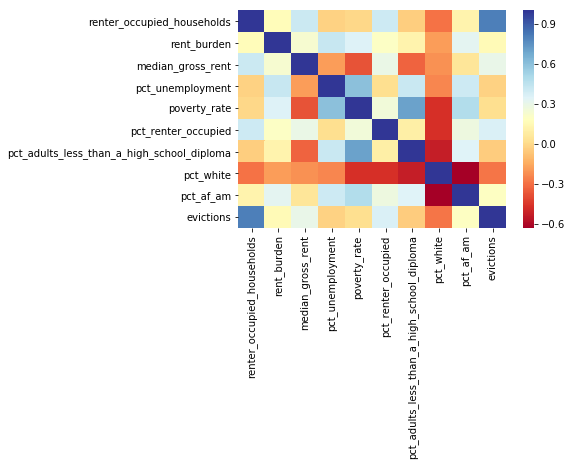

In [25]:
corr = df_clean.loc[:,int_cols].corr()
sns.heatmap(corr,cmap="RdYlBu" )

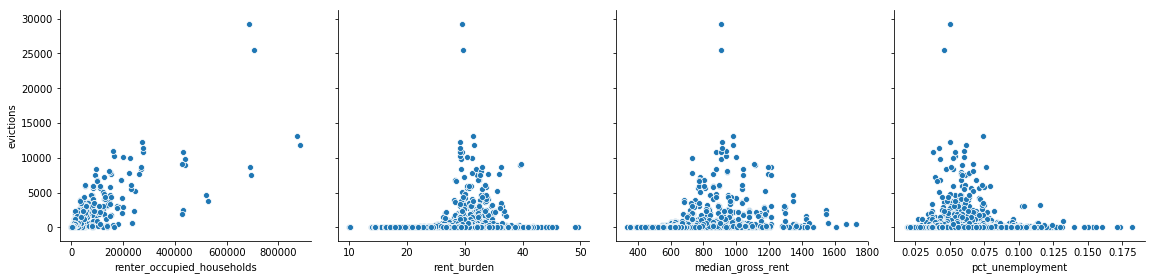

In [26]:
sns.pairplot(df_clean, y_vars=['evictions'],
                  x_vars= int_cols[:4],
            height=4)

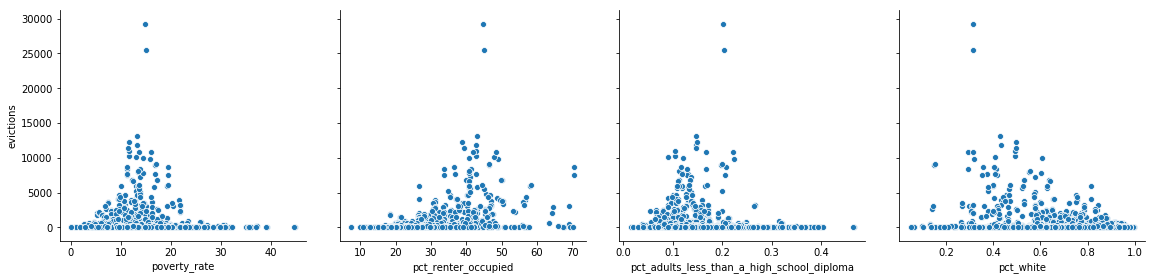

In [27]:
sns.pairplot(df_clean, y_vars=['evictions'],
                  x_vars= int_cols[4:8],
            height=4)

###  2.2. Explorer Categorical feautured

In [28]:
#explorer categorical (text) columns 
df_clean[raw_text_cols].apply(pd.Series.nunique).sort_values()

year                    2
economic_typology       6
rucc                    9
urban_influence        12
state                  45
county_code          1296
dtype: int64

In [29]:
# remove county_code because it is id and  althoug wasn't would be very cost process it
raw_text_cols.remove('county_code')
raw_text_cols.remove('state')
text_cols = raw_text_cols

In [30]:
def count_unique(df, cols):
    for col in cols:
        print('\n' + 'For column ' + col)
        print(df[col].value_counts())
        
count_unique(df_clean,text_cols)


For column year
b    1279
a    1267
Name: year, dtype: int64

For column rucc
Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area                         466
Nonmetro - Completely rural or less than 2,500 urban population, not adjacent to a metro area    370
Metro - Counties in metro areas of 1 million population or more                                  358
Nonmetro - Urban population of 2,500 to 19,999, not adjacent to a metro area                     337
Metro - Counties in metro areas of 250,000 to 1 million population                               289
Metro - Counties in metro areas of fewer than 250,000 population                                 261
Nonmetro - Completely rural or less than 2,500 urban population, adjacent to a metro area        210
Nonmetro - Urban population of 20,000 or more, adjacent to a metro area                          170
Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area                       85
Name: rucc, 

***well we can considered to transform a numercial economic_typology and ruuc***

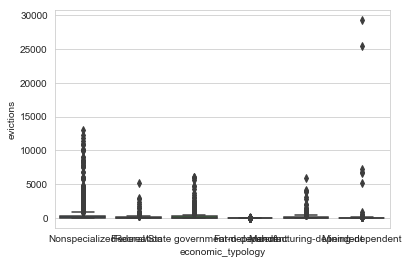

In [31]:
 
sns.set_style("whitegrid")
sns.boxplot('economic_typology', 'evictions', data=df_clean)
plt.xlabel('economic_typology') # Set text for the x axis
plt.ylabel('evictions')# Set text for y axis
plt.show()

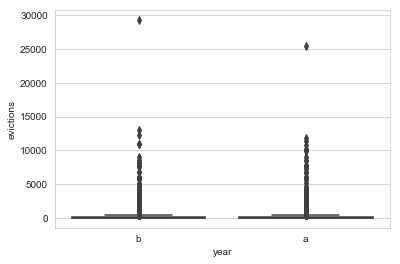

In [32]:
 
sns.set_style("whitegrid")
sns.boxplot('year', 'evictions', data=df_clean)
plt.xlabel('year') # Set text for the x axis
plt.ylabel('evictions')# Set text for y axis
plt.show()

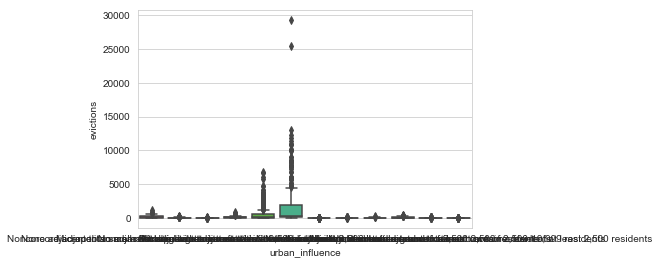

In [33]:
 
sns.set_style("whitegrid")
sns.boxplot('urban_influence', 'evictions', data=df_clean)
plt.xlabel('urban_influence') # Set text for the x axis
plt.ylabel('evictions')# Set text for y axis
plt.show()

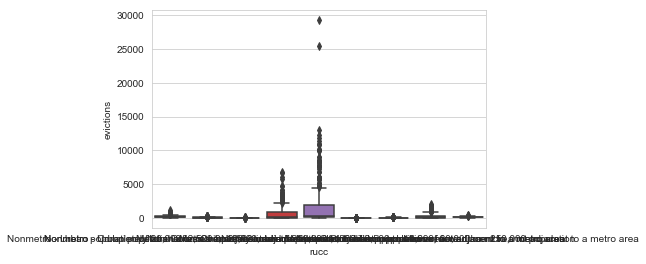

In [34]:
sns.set_style("whitegrid")
sns.boxplot('rucc', 'evictions', data=df_clean)
plt.xlabel('rucc') # Set text for the x axis
plt.ylabel('evictions')# Set text for y axis
plt.show()

## 3. Transforming

### String cols

In [35]:
print(df_clean['rucc'].unique())
Features = df_clean['rucc']
enc = preprocessing.LabelEncoder()
enc.fit(Features)
Features = enc.transform(Features)
print(Features)

['Nonmetro - Urban population of 20,000 or more, adjacent to a metro area'
 'Nonmetro - Urban population of 2,500 to 19,999, adjacent to a metro area'
 'Nonmetro - Completely rural or less than 2,500 urban population, adjacent to a metro area'
 'Metro - Counties in metro areas of 250,000 to 1 million population'
 'Metro - Counties in metro areas of 1 million population or more'
 'Nonmetro - Completely rural or less than 2,500 urban population, not adjacent to a metro area'
 'Nonmetro - Urban population of 2,500 to 19,999, not adjacent to a metro area'
 'Metro - Counties in metro areas of fewer than 250,000 population'
 'Nonmetro - Urban population of 20,000 or more, not adjacent to a metro area']
[7 5 3 ... 2 5 1]


In [36]:
ohe = preprocessing.OneHotEncoder()
encoded = ohe.fit(Features.reshape(-1,1))
Features = encoded.transform(Features.reshape(-1,1)).toarray()
Features[:10,:]

array([[0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0.]])

In [37]:
def encode_string(cat_feature):
    ## First encode the strings to numeric categories
    enc = preprocessing.LabelEncoder()
    enc.fit(cat_feature)
    enc_cat_feature = enc.transform(cat_feature)
    ## Now, apply one hot encoding
    ohe = preprocessing.OneHotEncoder()
    encoded = ohe.fit(enc_cat_feature.reshape(-1,1))
    return encoded.transform(enc_cat_feature.reshape(-1,1)).toarray()
    
categorical_columns= ['economic_typology','urban_influence','year']

for col in categorical_columns:
    temp = encode_string(df_clean[col])
    Features = np.concatenate([Features, temp], axis = 1)

print(Features.shape)
print(Features[:2, :])    

(2546, 29)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.
  0. 0. 0. 1. 0.]]


In [38]:
#explorer categorical (text) columns 
df_clean[text_cols].apply(pd.Series.nunique).sort_values()

year                  2
economic_typology     6
rucc                  9
urban_influence      12
dtype: int64

In [39]:
enc_cols = [
    'RUCC1', 'RUCC2','RUCC3','RUCC4','RUCC5','RUCC6','RUCC7','RUCC8','RUCC9',
    'ECT1','ECT2','ECT3','ECT4','ECT5','ECT6',
    'UI1','UI2','UI3','UI4','UI5','UI6','UI7','UI8','UI9','UI10','UI11','UI12',
    'YA','YB']

In [40]:
num_cols.remove('evictions')

In [41]:
cols = num_cols+enc_cols
cols

['population',
 'renter_occupied_households',
 'pct_renter_occupied',
 'median_gross_rent',
 'median_household_income',
 'median_property_value',
 'rent_burden',
 'pct_white',
 'pct_af_am',
 'pct_hispanic',
 'pct_am_ind',
 'pct_asian',
 'pct_nh_pi',
 'pct_multiple',
 'pct_other',
 'poverty_rate',
 'pct_civilian_labor',
 'pct_unemployment',
 'pct_uninsured_adults',
 'pct_uninsured_children',
 'pct_adult_obesity',
 'pct_diabetes',
 'pct_physical_inactivity',
 'heart_disease_mortality_per_100k',
 'pct_female',
 'pct_below_18_years_of_age',
 'pct_aged_65_years_and_older',
 'pct_adults_less_than_a_high_school_diploma',
 'pct_adults_with_high_school_diploma',
 'pct_adults_with_some_college',
 'pct_adults_bachelors_or_higher',
 'birth_rate_per_1k',
 'death_rate_per_1k',
 'RUCC1',
 'RUCC2',
 'RUCC3',
 'RUCC4',
 'RUCC5',
 'RUCC6',
 'RUCC7',
 'RUCC8',
 'RUCC9',
 'ECT1',
 'ECT2',
 'ECT3',
 'ECT4',
 'ECT5',
 'ECT6',
 'UI1',
 'UI2',
 'UI3',
 'UI4',
 'UI5',
 'UI6',
 'UI7',
 'UI8',
 'UI9',
 'UI10',
 

In [42]:
df_enc= np.concatenate([df_clean[num_cols],Features],axis=1)
df_enc = pd.DataFrame(df_enc, columns=cols)
df_enc = pd.concat([df_enc,df_clean['evictions']], axis=1)
df_enc.to_csv('df_enc.csv')

In [43]:
df_enc.head()

,population,renter_occupied_households,pct_renter_occupied,median_gross_rent,median_household_income,median_property_value,rent_burden,pct_white,pct_af_am,pct_hispanic,...,UI6,UI7,UI8,UI9,UI10,UI11,UI12,YA,YB,evictions
0,45009.000,6944.000,37.218,643.000,33315.000,98494.000,33.389,0.412,0.493,0.070,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,681
1,9872.000,1224.000,31.773,517.000,43724.000,85444.000,26.477,0.839,0.016,0.037,...,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0
2,17625.000,1725.000,21.973,671.000,37777.000,136162.000,32.500,0.874,0.041,0.047,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,29
3,134136.000,18180.000,36.809,603.000,30607.000,70062.000,31.959,0.264,0.241,0.081,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,841
4,6936.000,551.000,17.627,668.000,44237.000,187066.000,29.339,0.925,0.005,0.036,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,2


## transforming numerical data

In [44]:
data_norm = preprocessing.normalize(df_enc[num_cols], axis = 0)

In [45]:
df_trf = np.concatenate([data_norm,Features],axis=1)
df_trf = pd.DataFrame(df_trf, columns=cols)



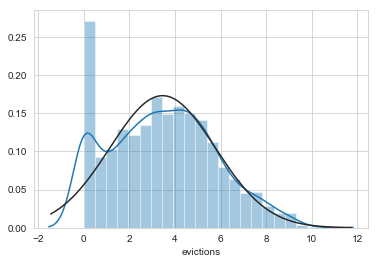

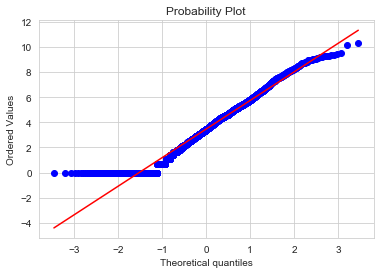

In [46]:
#We use the numpy fuction log1p which  applies log(1+x)  para manejar ceros to all elements of the column
df_trf['evictions'] = np.log1p(df_enc['evictions'])
sns.distplot(df_trf['evictions'], fit=ss.norm);

fig = plt.figure()
res = ss.probplot(df_trf['evictions'], plot=plt)
plt.show()

In [47]:
df_trf.to_csv('df_trf.csv')
print(df_trf.shape)

(2546, 63)


In [48]:
df_trf.head()

,population,renter_occupied_households,pct_renter_occupied,median_gross_rent,median_household_income,median_property_value,rent_burden,pct_white,pct_af_am,pct_hispanic,...,UI6,UI7,UI8,UI9,UI10,UI11,UI12,YA,YB,evictions
0,0.003,0.002,0.025,0.018,0.014,0.013,0.023,0.010,0.057,0.008,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,6.525
1,0.001,0.000,0.022,0.014,0.018,0.011,0.018,0.021,0.002,0.004,...,0.000,1.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000
2,0.001,0.001,0.015,0.019,0.016,0.018,0.022,0.022,0.005,0.006,...,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,3.401
3,0.008,0.007,0.025,0.017,0.013,0.009,0.022,0.007,0.028,0.010,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,6.736
4,0.000,0.000,0.012,0.019,0.018,0.025,0.020,0.023,0.001,0.004,...,0.000,0.000,0.000,0.000,0.000,0.000,1.000,1.000,0.000,1.099


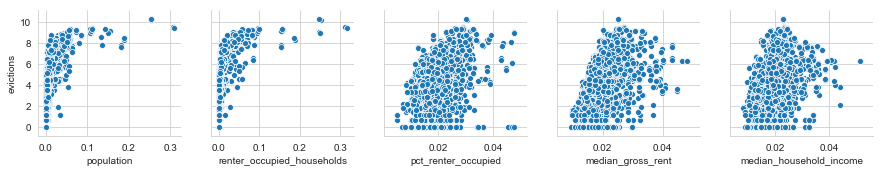

In [49]:
sns.pairplot(df_trf,x_vars=num_cols[:5], y_vars=['evictions'])

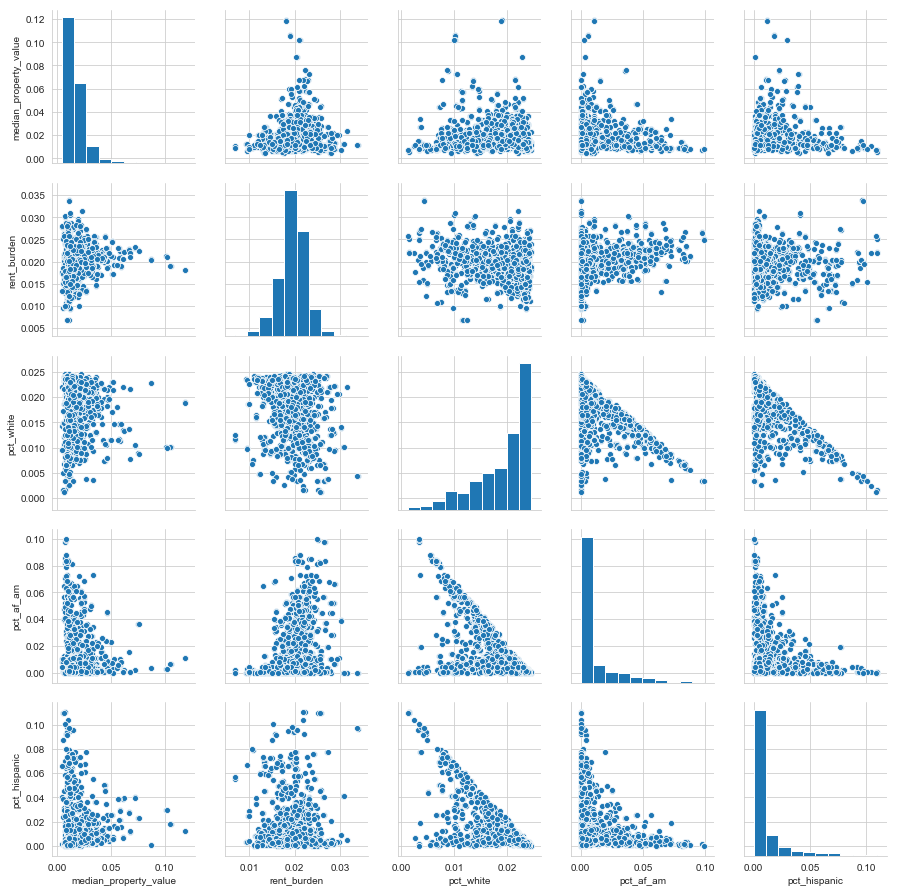

In [50]:
sns.pairplot(df_trf[num_cols[5:10]])